<a href="https://colab.research.google.com/github/kooose38/pystan_practice/blob/main/%E9%87%8D%E5%9B%9E%E5%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip data.zip 

Archive:  data.zip
  inflating: data/data.xlsx          
  inflating: data/dose_response.xlsx  
  inflating: data/MAP_sample.xlsx    
  inflating: data/multilevel_modeling.xlsx  
  inflating: data/real_estate1.xlsx  
  inflating: data/real_estate2.xlsx  
  inflating: data/temperature_series.xlsx  
  inflating: data/~$wattage.xlsx     


In [2]:
!pip install -q pystan 

In [15]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import mstats 
import pystan 
import datetime 

In [14]:
plt.style.use("ggplot")

複数の説明変数から事後分布を求める(ベイズ重回帰)  
物件価格は駅からの距離、部屋の大きさ、築年数の線形結合で表せる*正規分布*であると仮定する。  


In [5]:
df = pd.read_excel("data/real_estate2.xlsx")
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


(array([ 2.,  6., 11., 27., 30., 31., 22., 31., 26., 11.]),
 array([2.51851394, 2.65184951, 2.78518507, 2.91852064, 3.0518562 ,
        3.18519177, 3.31852734, 3.4518629 , 3.58519847, 3.71853403,
        3.8518696 ]),
 <a list of 10 Patch objects>)

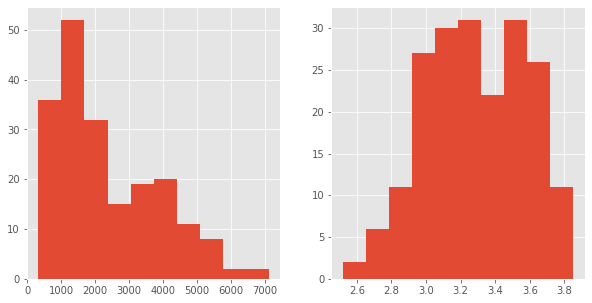

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()
ax[0].hist(df["value"])
ax[1].hist(np.log10(df["value"]))

In [36]:
df["value"] = np.log10(df["value"]) 

In [22]:
this_year = str(datetime.datetime.today()).split("-")[0]
df["year"] = df["year"].apply(lambda x: int(this_year) - x)

In [24]:
df.distance.unique().tolist()

['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-']

In [26]:
dis_arr = {v: k for k, v in enumerate(df.distance.unique().tolist())}

In [27]:
dis_arr

{'-': 5, 'バス': 4, '徒歩10分以内': 0, '徒歩15分以内': 1, '徒歩15分超': 3, '徒歩5分以内': 2}

In [28]:
df = df[df["distance"] != "-"].reset_index(drop=True)
df["distance"] = df["distance"].map(dis_arr)

In [33]:
usecols = ["distance", "space", "year", "value"]
df = df[usecols]

In [38]:
df.head()

,distance,space,year,value
0,0,70,39,2.959041
1,0,70,39,3.049218
2,0,70,39,3.075547
3,0,70,39,3.075547
4,0,70,39,3.075547


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


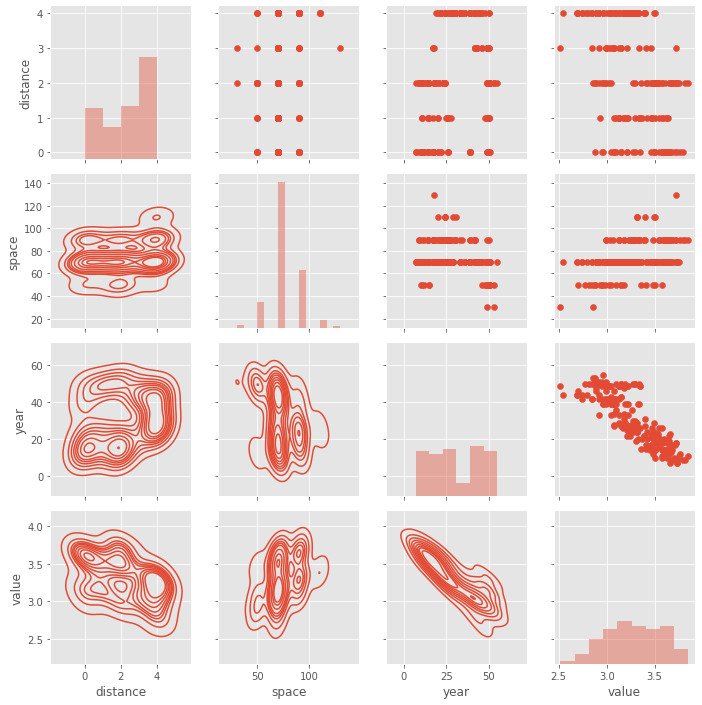

In [37]:
g = sns.PairGrid(df)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(plt.scatter)

In [49]:
stan_model = """
data {
    int N;
    real year[N];
    real dis[N];
    real space[N];
    real Y[N];
}

parameters {
    real d; 
    real s;
    real y;
    real b;
    real<lower=0> sigma;
}

model {
    real mu;
    for(i in 1:N) {
        mu = d * dis[i] + s * space[i] + y * year[i] + b;
        Y[i] ~ normal(mu, sigma);
    }
}

"""

In [50]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d9d2ea977d87a20c39612721e7123d10 NOW.


In [51]:
stan_data = {"N": df.shape[0], "year": df.year, "dis": df.distance, "space": df.space, "Y": df["value"]}

In [52]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [53]:
fit

Inference for Stan model: anon_model_d9d2ea977d87a20c39612721e7123d10.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d      -0.06  1.2e-4 6.3e-3  -0.07  -0.06  -0.06  -0.05  -0.04   2721    1.0
s     4.6e-3  1.4e-5 6.8e-4 3.3e-3 4.2e-3 4.6e-3 5.1e-3 6.0e-3   2297    1.0
y      -0.01  1.3e-5 7.1e-4  -0.02  -0.01  -0.01  -0.01  -0.01   2878    1.0
b        3.5  1.3e-3   0.06   3.38   3.46   3.49   3.54   3.61   2135    1.0
sigma   0.13  1.3e-4 6.4e-3   0.11   0.12   0.13   0.13   0.14   2487    1.0
lp__  308.54    0.04   1.57 304.93 307.66 308.83 309.72 310.61   1565    1.0

Samples were drawn using NUTS at Wed Jan  5 08:46:28 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

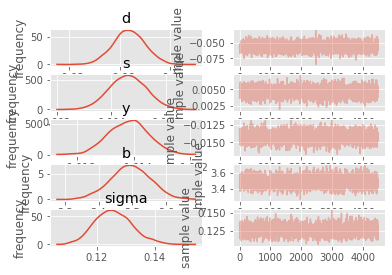

In [54]:
fig = fit.plot()

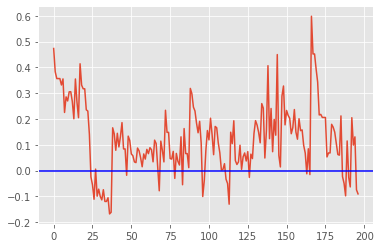

In [68]:
d, s, y, b = -0.06, 4.6e-3, -0.01, 3.5

Y = d * df["distance"] + s * df["space"] + y * df["year"] + b 

error = Y - df["value"]
plt.plot(error)
plt.axhline(y=0, xmin=0.0, xmax=200.0, color="b")